In [1]:
import json
import os
from collections.abc import Callable

import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [2]:
def log_score_level_curve(target: float, dash: str) -> go.Scatter:
    x = np.linspace(0, 1 - np.exp(-target), 201)
    y = 1 - x - np.exp(-target)

    line_trace = go.Scatter(
        x=x,
        y=y,
        showlegend=False,
        mode="lines",
        line={"color": "red", "width": 2, "dash": dash},
    )

    return line_trace


def brier_level_curve(target: float, dash: str) -> go.Scatter:
    x = np.linspace(0, np.sqrt(2 * target / 3), 201)
    disc = np.sqrt(np.maximum(0, -3 * x**2 + 2 * target))
    y = (-x + disc) / 2
    x = x[y >= 0]
    y = y[y >= 0]
    line_trace = go.Scatter(
        x=x,
        y=y,
        showlegend=False,
        mode="lines",
        line={"color": "red", "width": 2, "dash": dash},
    )

    return line_trace

In [3]:
def log_score_metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return -np.log(1 - x - y)


def brier_score_metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return x**2 + y**2 + (x + y) ** 2

In [4]:
def make_plot(
    metric_name: str, calc_metric: Callable, level_curve: Callable, levels: list[float]
) -> go.Figure:
    n_points = 250
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)

    xv, yv = np.meshgrid(x, y)
    xv = xv.flatten()
    yv = yv.flatten()
    inx = (xv + yv) < 0.99
    xv = xv[inx]
    yv = yv[inx]

    zv = calc_metric(xv, yv)

    heatmap_trace = go.Scatter(
        x=xv,
        y=yv,
        showlegend=False,
        mode="markers",
        marker={
            "size": 5,
            "color": zv,
            "colorscale": "Viridis",
            "colorbar": {"tickfont": {"size": 12}, "len": 1, "x": 1.05},
        },
    )

    point_trace = go.Scatter(
        x=[1 / 3],
        y=[1 / 3],
        showlegend=False,
        mode="markers",
        marker={"color": "red", "size": 10, "symbol": "x"},
    )

    title = f"{metric_name} assuming the observed result is a victory"
    fig = go.Figure(
        [heatmap_trace, point_trace] + [level_curve(level, "dash") for level in levels]
    )
    fig.update_layout(
        width=650,
        height=600,
        plot_bgcolor="white",
        paper_bgcolor="white",
        title=title,
        xaxis_title="Probability of Draw",
        yaxis_title="Probability of Defeat",
        xaxis={"scaleanchor": "y", "scaleratio": 1},
        yaxis={"constrain": "domain"},
    )

    return fig

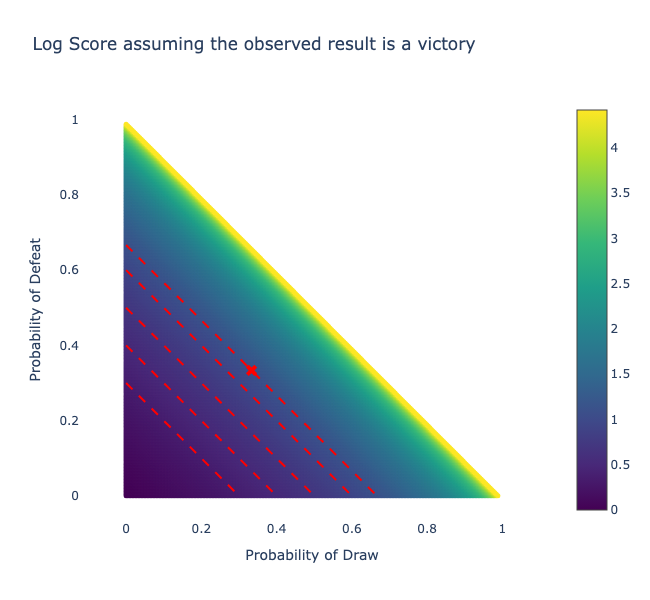

In [5]:
log_score_plot = make_plot(
    "Log Score",
    log_score_metric,
    log_score_level_curve,
    [-np.log(1 / 3), -np.log(0.4), -np.log(0.5), -np.log(0.6), -np.log(0.7)],
)

log_score_plot.show("png")

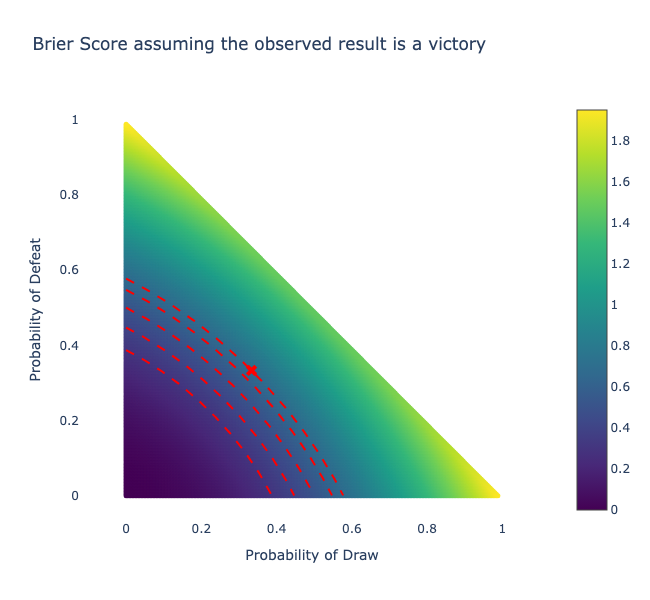

In [6]:
brier_score_plot = make_plot(
    "Brier Score", brier_score_metric, brier_level_curve, [2 / 3, 0.6, 0.5, 0.4, 0.3]
)

brier_score_plot.show("png")

In [7]:
def get_predictions(
    championship: str, seasons: list[int]
) -> dict[str, list[np.ndarray]]:
    all_predictions = {}
    map_results = {"H": 0, "D": 1, "A": 2}
    for s in seasons:
        file_name = os.path.join(
            "..", "real_data", "results", championship, str(s), "all_matches.json"
        )

        with open(file_name) as f:
            data = json.load(f)

        for game_data in data.values():
            result = game_data.get("result")
            probs = game_data.get("probabilities")
            if probs is None:
                continue

            result_index = map_results[result]
            for model, predictions in probs.items():
                if model not in all_predictions:
                    all_predictions[model] = []

                pred_key = str(max(list(map(int, predictions.keys()))))
                inner_pred = predictions[pred_key].copy()
                inner_pred.pop(result_index)
                if "naive" not in model:
                    all_predictions[model].append(sorted(inner_pred))
                else:
                    all_predictions[model].append(inner_pred)

    return all_predictions

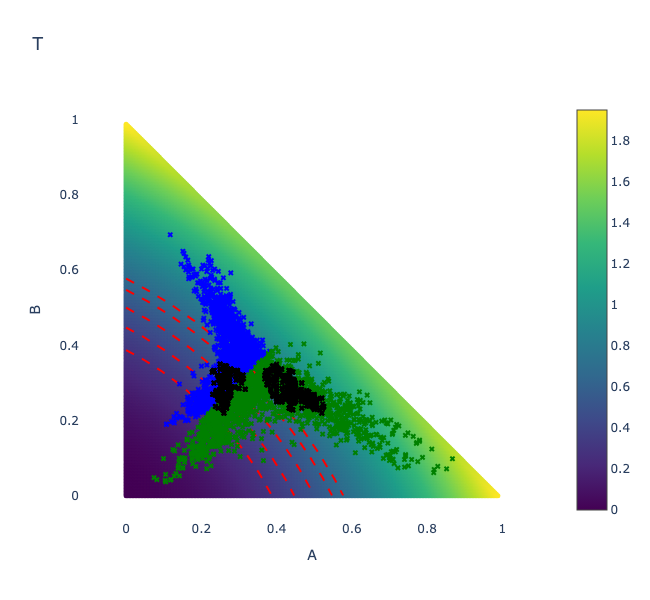

In [8]:
brazil_predictions = get_predictions("brazil", [*range(2020, 2025)])
plot = make_plot("", brier_score_metric, brier_level_curve, [2 / 3, 0.6, 0.5, 0.4, 0.3])

plot.add_trace(
    go.Scatter(
        x=np.array(brazil_predictions["poisson_2"])[:, 0],
        y=np.array(brazil_predictions["poisson_2"])[:, 1],
        showlegend=False,
        mode="markers",
        marker={"color": "blue", "size": 5, "symbol": "x"},
    )
)

plot.add_trace(
    go.Scatter(
        x=np.array(brazil_predictions["poisson_4"])[:, 1],
        y=np.array(brazil_predictions["poisson_4"])[:, 0],
        showlegend=False,
        mode="markers",
        marker={"color": "green", "size": 5, "symbol": "x"},
    )
)

plot.add_trace(
    go.Scatter(
        x=np.array(brazil_predictions["naive_2"])[:, 0],
        y=np.array(brazil_predictions["naive_2"])[:, 1],
        showlegend=False,
        mode="markers",
        marker={"color": "black", "size": 5, "symbol": "x"},
    )
)

plot.update_layout(
    title="T",
    xaxis_title="A",
    yaxis_title="B",
)

plot.show("png")

In [9]:
championships = ["brazil", "england", "italy", "spain"]
results = pd.DataFrame(
    columns=["championship", "model", "games", "brier_score", "log_score"]
)
for championship in championships:
    predictions = get_predictions(championship, [*range(2020, 2025)])
    for model in predictions:
        preds = np.array(predictions[model])
        bs = np.mean(brier_score_metric(preds[:, 0], preds[:, 1]))
        ls = np.mean(log_score_metric(preds[:, 1], preds[:, 0]))
        results.loc[len(results)] = [championship, model, len(preds), bs, ls]

results.sort_values(by="brier_score", ascending=True, ignore_index=True)

,championship,model,games,brier_score,log_score
0,italy,poisson_4,1650,0.593196,0.995893
1,england,bradley_terry_3,1650,0.595834,0.998716
2,england,bradley_terry_4,1650,0.595982,0.999008
3,england,poisson_4,1650,0.596207,0.999634
4,italy,poisson_3,1650,0.596644,1.000908
5,italy,poisson_1,1650,0.599227,1.002738
6,england,poisson_2,1650,0.602337,1.007470
7,italy,bradley_terry_4,1650,0.602470,1.008045
8,italy,bradley_terry_3,1650,0.602727,1.008340
9,england,poisson_3,1650,0.602789,1.008978
